# Create new library designer function

Import data.

In [2]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
print('load data')
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

load data


In [3]:
building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630.fpb')

# align fingerprints to building blocks
print('align fingerprints')
fingerprints = dg.utils.sort_fingerprints(fingerprints, building_blocks)

align fingerprints


Create inputs to the DrugEnv.

In [4]:
import numpy as np
from dgym.envs.library_designer import LibraryDesigner
from dgym.envs.oracle import DGLOracle, RDKitOracle, DockingOracle
from dgym.envs.evaluator import ClassicEvaluator, UtilityFunction

# create library designer
library_designer = LibraryDesigner(
    reactions,
    building_blocks,
    fingerprints
)

Testing the best performing molecule from docking screen.

In [4]:
%%time
mol = dg.molecule.Molecule(
    'Cc1ccccc1C(=O)Nc1nc(-c2cccc(O)c2)cs1',
    reactants = [
        dg.molecule.Molecule('Cc1ccccc1C(=O)O'),
        dg.molecule.Molecule('Nc1nc(-c2cccc(O)c2)cs1'),
    ]
)

library_designer.reset_cache()

analogs = library_designer.design(
    molecule = deck[0],
    num_analogs = 20,
    temperature = 0.0
)
# [display(a) for a in analogs]

CPU times: user 104 ms, sys: 239 µs, total: 104 ms
Wall time: 103 ms


In [5]:
import numpy as np
from dgym.envs.library_designer import LibraryDesigner
from dgym.envs.oracle import DGLOracle, RDKitOracle, DockingOracle
from dgym.envs.evaluator import ClassicEvaluator, UtilityFunction

# create library designer
library_designer = LibraryDesigner(
    reactions,
    building_blocks,
    fingerprints
)

# create docking oracle
config = {
    'center_x': 9.812,
    'center_y': -0.257,
    'center_z': 20.8485,
    'size_x': 14.328,
    'size_y': 8.85,
    'size_z': 12.539,
    'exhaustiveness': 128,
    'max_step': 20,
    'num_modes': 9,
    'scoring': 'vinardo',
    'refine_step': 3,
    'seed': 5
}

docking_oracle = DockingOracle(
    'Mpro affinity',
    receptor_path=f'{path}/Mpro_prepped.pdbqt',
    config=config
)

In [26]:
best_analog.reactants[1].smiles

'O=C1CCCCc2cc(O)ccc21'

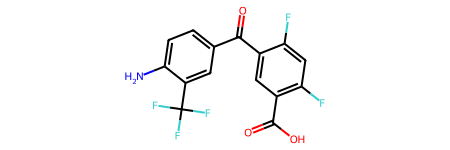

4.78480866250603


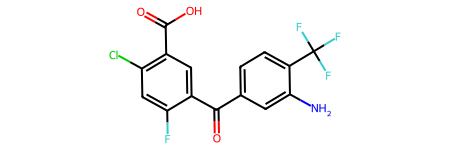

5.405556641289669


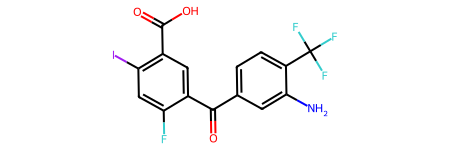

5.457190936616012


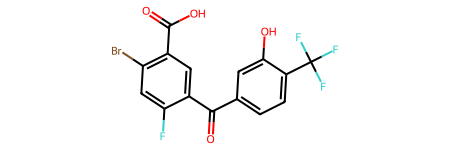

5.537262374963469


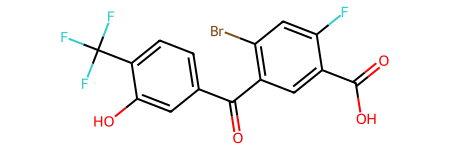

5.327521941126921


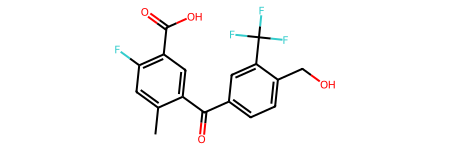

4.973281431305881


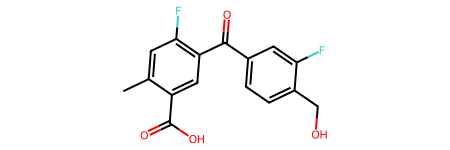

5.212631217084513


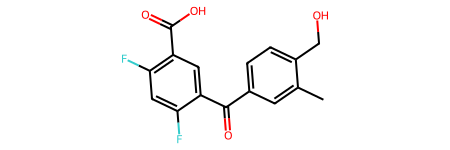

5.033358997204941


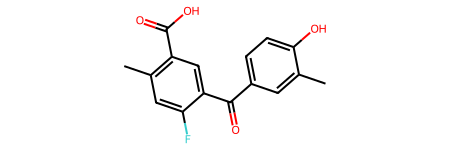

5.131183068757635


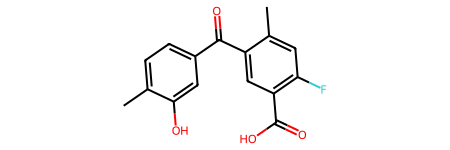

5.200533853379047


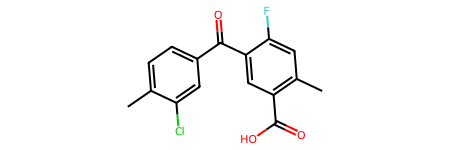

5.2629512448439595


In [38]:
from tqdm.notebook import tqdm

library_designer.reset_cache()

# best_analog = dg.molecule.Molecule(
#     'Nc1cccc(-c2csc(Nc3ccccc3C(=O)O)n2)c1',
#     reactants = [
#         dg.molecule.Molecule('O=C(O)c1ccccc1Br'),
#         dg.molecule.Molecule('Nc1cccc(-c2csc(N)n2)c1'),
#     ]
# )
# display(best_analog)
# print(5.220108806402527)

# best_analog = dg.molecule.Molecule(
#     'O=C1CCCCc2cc(Oc3cccc(O)c3C(=O)O)ccc21',
#     reactants = [
#         dg.molecule.Molecule('O=C(O)c1c(O)cccc1Cl'),
#         dg.molecule.Molecule('O=C1CCCCc2cc(O)ccc21'),
#     ]
# )
# display(best_analog)
# print(5.753656144113496)


best_analog = dg.molecule.Molecule(
    'Nc1ccc(C(=O)c2cc(C(=O)O)c(F)cc2F)cc1C(F)(F)F',
    reactants = [
        dg.molecule.Molecule('N#Cc1ccc(N)c(C(F)(F)F)c1'),
        dg.molecule.Molecule('O=C(O)c1cc(Cl)c(F)cc1F'),
    ]
)

display(best_analog)
print(4.78480866250603)

# best_analog = dg.molecule.Molecule(
#     'N#CN(C(=O)Cc1ccc2cn[nH]c2c1)c1cccc(C(=O)O)c1',
#     reactants = [
#         dg.molecule.Molecule('O=C(O)Cc1ccc2cn[nH]c2c1'),
#         dg.molecule.Molecule('N#CNc1cccc(C(=O)O)c1'),
#     ]
# )

# display(best_analog)
# print(7.123005139339721)

# best_analog = dg.molecule.Molecule(
#     'O=C(c1ccc2c(c1)CC2)c1cnc(F)c(C(=O)O)c1',
#     reactants = [
#         dg.molecule.Molecule('N#Cc1cnc(F)c(C(=O)O)c1'),
#         dg.molecule.Molecule('Brc1ccc2c(c1)CC2'),
#     ]
# )

# display(best_analog)
# print(7.244001238124934)


# best_analog = dg.molecule.Molecule(
#     'O=C(c1ccc2c(c1)CCCC2)c1ccc(F)c(C(=O)O)c1',
#     reactants = [
#         dg.molecule.Molecule('N#Cc1ccc(F)c(C(=O)O)c1'),
#         dg.molecule.Molecule('Brc1ccc2c(c1)CCCC2'),
#     ]
# )

# display(best_analog)
# print(7.462370863410115)

# best_analog = dg.molecule.Molecule(
#     'O=C(O)c1c(F)ccc(Oc2ccc3c(c2)CCNC3)c1F',
#     reactants = [
#         dg.molecule.Molecule('Brc1ccc2c(c1)CCNC2.Cl'),
#         dg.molecule.Molecule('O=C(O)c1c(F)ccc(O)c1F'),
#     ]
# )

# display(best_analog)
# print(7.66805169179407)

for _ in range(10):

    analogs = library_designer.design(
        molecule = best_analog,
        num_analogs = 50,
        temperature = 0.0
    )

    if analogs:
        
        results = docking_oracle(analogs)
        
        best = np.nanargmax(results).item()
        best_analog = analogs[best]
        best_result = results[best]
        
        display(best_analog)
        print(best_result)

Text(10, 10, '0.00039445655710210626')

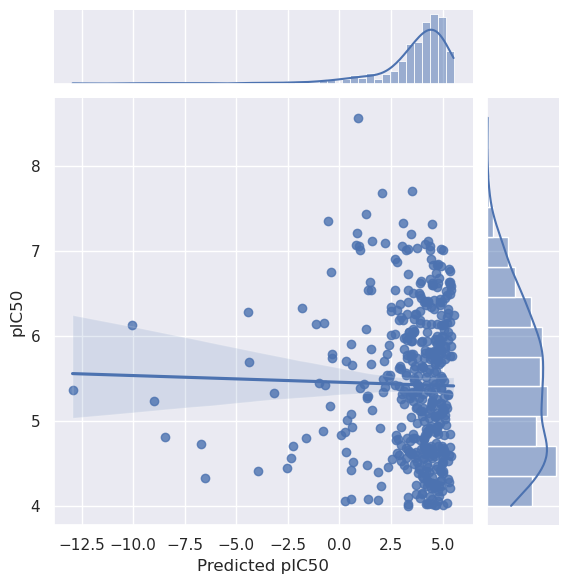

In [309]:
from scipy import stats
import matplotlib.pyplot as plt

def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

j = sns.jointplot(df.dropna(), x='Predicted pIC50', y='pIC50', kind="reg")
j.ax_joint.annotate(r2(j.x, j.y), (10, 10))